In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
import time
from sklearn.metrics import mean_squared_log_error
%matplotlib inline 

In [2]:
def mean_relative_error(target_values, predicted_values):
    return sum(abs(target_values - predicted_values))/sum(target_values)

def median_relative_error(target_values, predicted_values):
    return np.median(abs(target_values - predicted_values)/target_values)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_prediction_2(y_test, y_test_predicted, y_train, y_train_predicted) -> str:  
    test_mse = mean_squared_error(y_test, y_test_predicted)
    print('test_mse:', round(test_mse, 4))
    train_mse = mean_squared_error(y_train, y_train_predicted)
    print('train_mse:', round(train_mse, 4))
    test_rmse = mean_squared_error(y_test, y_test_predicted, squared=False)
    print('test_rmse:', round(test_rmse, 4))
    train_rmse = mean_squared_error(y_train, y_train_predicted, squared=False)
    print('train_rmse:', round(train_rmse, 4))
    test_mae = mean_absolute_error(y_test, y_test_predicted)
    print('test_mae:', round(test_mae, 4))
    train_mae = mean_absolute_error(y_train, y_train_predicted)
    print('train_mae:', round(train_mae, 4))
    test_mre = mean_relative_error(y_test, y_test_predicted)
    print('test_mre:', round(test_mre, 4))
    train_mre = mean_relative_error(y_train, y_train_predicted)
    print('train_mre:', round(train_mre, 4))
    test_medAE = median_absolute_error(y_test, y_test_predicted)
    print('test_medAE:', round(test_medAE, 4))
    train_medAE = median_absolute_error(y_train, y_train_predicted)
    print('train_medAE:', round(train_medAE, 4))
    test_medRE = median_relative_error(y_test, y_test_predicted)
    print('test_medRE:', round(test_medRE, 4))
    train_medRE = median_relative_error(y_train, y_train_predicted)
    print('train_medRE:', round(train_medRE, 4))
    test_mape = mean_absolute_percentage_error(y_test, y_test_predicted)
    print('test_mape:', round(test_mape, 4))
    train_mape = mean_absolute_percentage_error(y_train, y_train_predicted)
    print('train_mape:', round(train_mape, 4))
    return evaluate_prediction_2

In [3]:
input_file = open("D:\Master\Projekt im Master\DataSet\joinedExportv4.csv", "r")
df = pd.read_csv(input_file)
#df = pd.read_csv(input_file, nrows = 1000)


In [4]:
df.shape

(1562820, 198)

In [5]:
sample_size = df.shape[0]

In [6]:
newdf = df.rename(columns= {'timeBin20WWDSId': 'TripStartTime', 'startSGC15IndexX' : 'Pickup X-axis', 'startSGC15IndexY' : 'Pickup Y-axis', 'endSGC15IndexX' : 'Dropoff X-axis', 'endSGC15IndexY' : 'Dropoff Y-axis'})

In [9]:
feature_set = ['startTimeWeek', 'startTimeDay', 'TripStartTime', 'weatherHourlyTemp', 'weatherHourlyWind', 'weatherHourlyHumidity', 'weatherHourlyBarometer', 'Pickup X-axis', 'Pickup Y-axis', 'Dropoff X-axis', 'Dropoff Y-axis']
y_f = 'tripDuration'
sample_size = 1400000

In [10]:
import xgboost as xgb 

In [11]:
xgboost_params = {
    'objective': 'reg:squarederror', 
    'base_score': 0.5, 
    'booster': 'gbtree', 
    'colsample_bylevel': 1, 
    'colsample_bynode': 1, 
    'colsample_bytree': 1, 
    'gamma': 0.013694878336707128, 
    'gpu_id': -1, 
    'importance_type': 'gain', 
    'interaction_constraints': '', 
    'learning_rate': 0.300000012, 
    'max_delta_step': 0, 
    'max_depth': 15, 
    'min_child_weight': 6, 
    'monotone_constraints': '()', 
    'n_estimators': 200, 
    'n_jobs': 0, 
    'num_parallel_tree': 1, 
    'random_state': 0, 
    'reg_alpha': 0, 
    'reg_lambda': 1, 
    'scale_pos_weight': 1, 
    'subsample': 0.8740780229393212, 
    'tree_method': 'exact', 
    'validate_parameters': 1, 
    'verbosity': None,
    
}
#seed=17   
# Divide the main data into X and y and convert both of them into numpy
random_sample = newdf.sample(sample_size)

#X= random_sample[feature_set].to_numpy()# Chagne to get lime working
X= random_sample[feature_set]#To get feature names typed in SHAP and to create SHAP waterfall plots

#y = np.ravel(random_sample[y_f].to_numpy())#Chagne to get lime working
y = np.ravel(random_sample[y_f])#To get feature names typed in SHAP and to create SHAP waterfall plots

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

model = xgb.XGBRegressor(**xgboost_params)
start = int(time.time())
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, early_stopping_rounds=10, verbose=False)
end = int(time.time())
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

print(f'XGBoost; {int(end-start)};{evaluate_prediction_2(y_test, y_test_predicted, y_train, y_train_predicted)}')

print("Test R2 score: {:.2f}".format(model.score(X_test, y_test)))

test_mse: 43414.941
train_mse: 19025.1506
test_rmse: 208.3625
train_rmse: 137.9317
test_mae: 141.6695
train_mae: 96.0881
test_mre: 0.1796
train_mre: 0.1218
test_medAE: 99.6887
train_medAE: 70.5145
test_medRE: 0.1597
train_medRE: 0.1102
test_mape: 23.2982
train_mape: 17.3425
XGBoost; 181;<function evaluate_prediction_2 at 0x000001266FC755E0>
Test R2 score: 0.86


In [12]:
#predictions and real values:
for c in range(0,10):
    print(c,'Prediction:',y_test_predicted[c], ' Real value:',y_test[c])

0 Prediction: 1184.1265  Real value: 853
1 Prediction: 1409.7921  Real value: 849
2 Prediction: 808.96924  Real value: 684
3 Prediction: 348.4174  Real value: 144
4 Prediction: 602.13055  Real value: 617
5 Prediction: 616.966  Real value: 535
6 Prediction: 792.96313  Real value: 1106
7 Prediction: 388.237  Real value: 233
8 Prediction: 1149.1797  Real value: 955
9 Prediction: 551.3973  Real value: 384


Text(0, 0.5, 'Predicion Samples (Estimated time in seconds)')

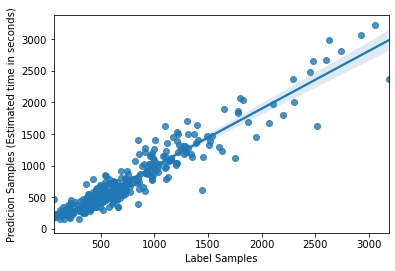

In [13]:
sampley_test= y_test[:300:]
sampley_predreal= y_test_predicted[:300:]
sns.regplot(x = sampley_test, y = sampley_predreal)
plt.xlabel("Label Samples")
plt.ylabel("Predicion Samples (Estimated time in seconds)")

In [14]:
len(y_test), len (y_test_predicted)

(280000, 280000)

In [15]:
y_test_predicted.mean()

789.2994

# 1.Feature Importance with SHAP

One way of showing the variatoin of features importance is by using shap explainers. For more details see: 
https://shap.readthedocs.io/en/latest/
and
https://christophm.github.io/interpretable-ml-book/shap.html
Source code of this section has been modified from:
https://shap.readthedocs.io/en/latest/example_notebooks/tree_explainer/Fitting%20a%20Linear%20Simulation%20with%20XGBoost.html

In [16]:
import shap 
shap.initjs()

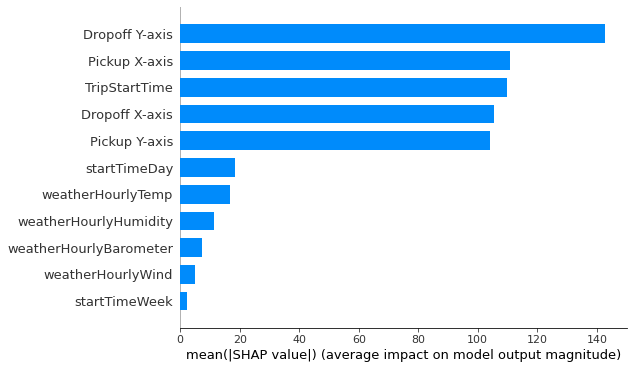

In [17]:
XGB_explainers = shap.TreeExplainer(model)
XGB_shap_values = XGB_explainers.shap_values(X_test)
shap.summary_plot(XGB_shap_values, feature_set, plot_type="bar")

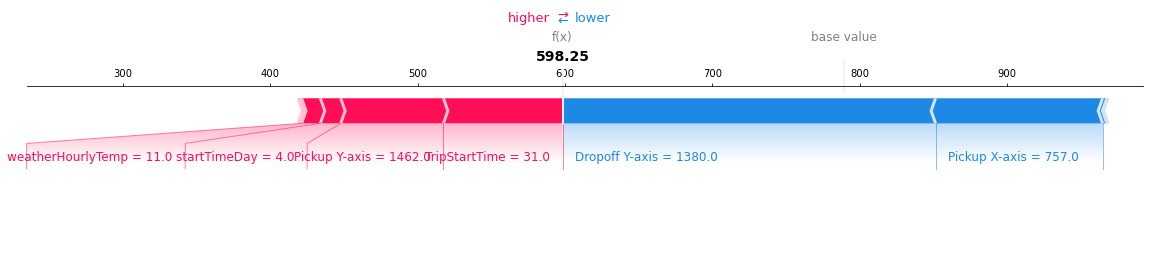

In [46]:
shap.force_plot(XGB_explainers.expected_value, XGB_shap_values[1010], X_test.iloc[1010],feature_set,matplotlib=True, show=True)

In [19]:
XGB_explainers1 = shap.Explainer(model)
XGB_shap_values1 = XGB_explainers1(X_test)

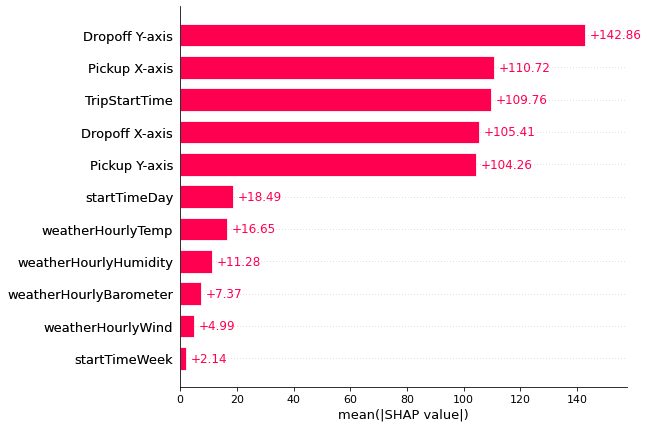

In [20]:
shap.plots.bar(XGB_shap_values1,max_display=11)

#### Summary bee-swarm plot shows the global importance of each feature and the distribution of its effect:
1. Y-axis shows the order of importance.
2. X-axis shows the shap vaules.
3. Color of the dot shows the size of the impact, Blue is low while Red is high.

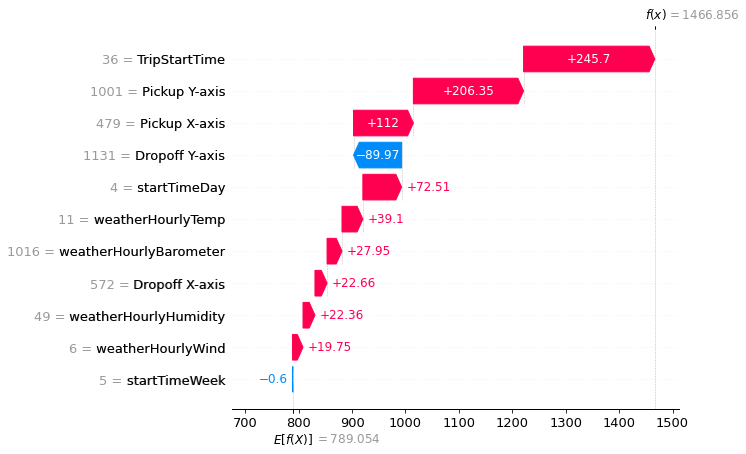

In [120]:
shap.plots.waterfall(XGB_shap_values1[14], max_display=11)

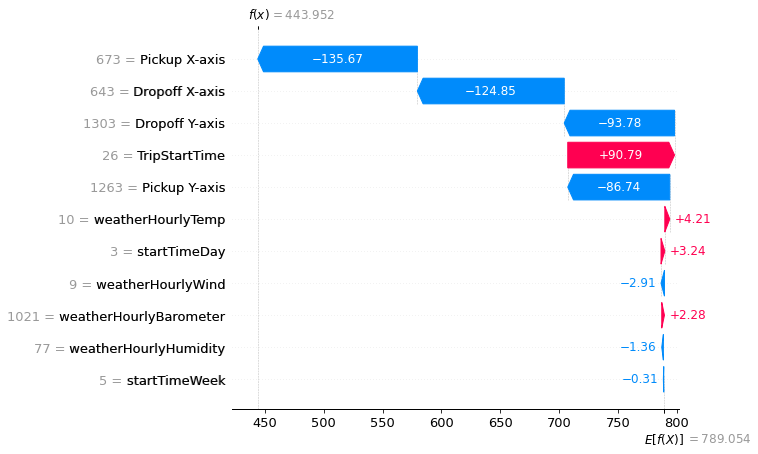

In [133]:
shap.plots.waterfall(XGB_shap_values1[25], max_display=11)

# 2. LIME (Local Interpretable Model-agnostic Explanations).  
For more information about and code implementations, you can see:
https://marcotcr.github.io/lime/tutorials/Using%2Blime%2Bfor%2Bregression.html
and:
https://www.kaggle.com/prashant111/explain-your-model-predictions-with-lime?scriptVersionId=28590264

In [26]:
import lime
import lime.lime_tabular

In [30]:
XGB_Lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names = feature_set, class_names=['tripDuration'], 
                                                   verbose=True, mode='regression')

In [ ]:
XGBLime_exp1 = XGB_Lime_explainer.explain_instance(X_test.values[0], model.predict(X_test.values), num_features=11)

In [ ]:
XGBLime_exp1.show_in_notebook(show_table=True)

#### Lime explanations for a single instance

# 3. Explaining XGBoost Model using PDP (Partial Dependece Plots).
PDPs shows the relationship between a certain feature and the payout. For more details and code implementaion, kindly see:
https://www.kaggle.com/dansbecker/partial-dependence-plots and:
https://towardsdatascience.com/prettifying-partial-density-plots-in-python-1f7216937ff

In [141]:
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [142]:
# To plot each feature indivisually
def PD_plot(A,B):
    PDP_plot = plot_partial_dependence(model,       
                                   features=[A,B], 
                                   X=X,
                                   feature_names=['startTimeWeek', 'startTimeDay', 'TripStartTime', 'weatherHourlyTemp', 'weatherHourlyWind', 'weatherHourlyHumidity', 'weatherHourlyBarometer', 'Pickup X-axis', 'Pickup Y-axis', 'Dropoff X-axis', 'Dropoff Y-axis'],
                                   target='tripDuration', grid_resolution=10)
    return PDP_plot   

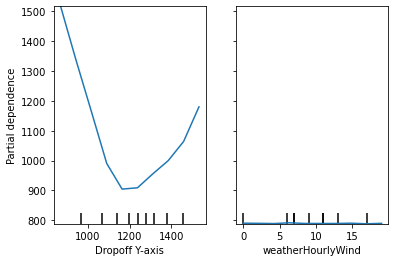

In [144]:
PD_plot(10,4)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

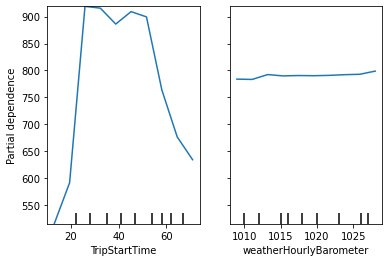

In [143]:
PD_plot(2,6)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

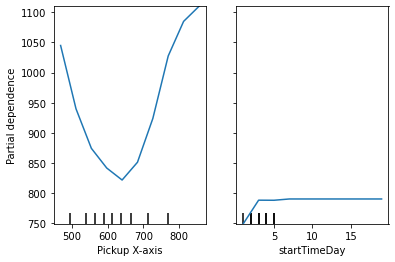

In [25]:
PD_plot(7,1)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

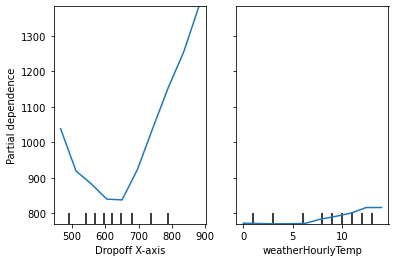

In [26]:
PD_plot(9,3)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

In [27]:
def PD_plot(A):
    PDP_plot = plot_partial_dependence(model,       
                                   features=[A], 
                                   X=X,
                                   feature_names=['startTimeWeek', 'startTimeDay', 'TripStartTime', 'weatherHourlyTemp', 'weatherHourlyWind', 'weatherHourlyHumidity', 'weatherHourlyBarometer', 'Pickup X-axis', 'Pickup Y-axis', 'Dropoff X-axis', 'Dropoff Y-axis'],
                                   target='tripDuration', grid_resolution=10)
    return PDP_plot   

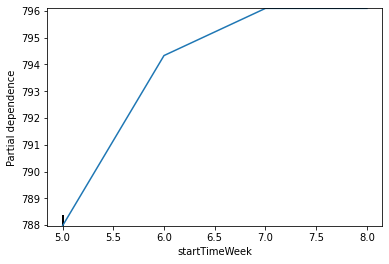

In [28]:
PD_plot(0)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

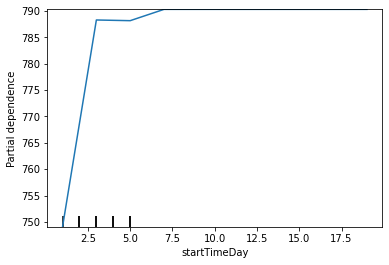

In [29]:
PD_plot(1)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

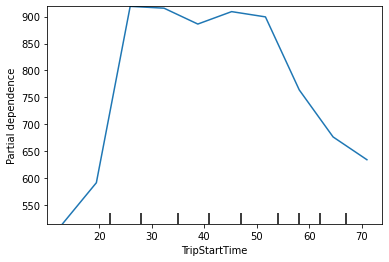

In [30]:
PD_plot(2)#<--- To plot a feature, change the number according to the feature (between 0 and 10

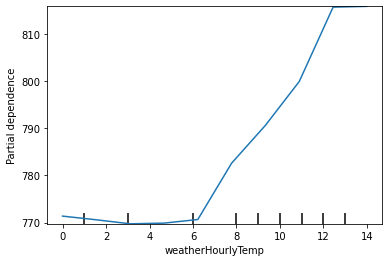

In [31]:
PD_plot(3)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

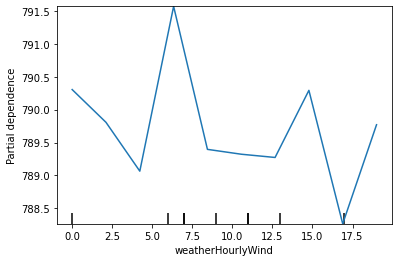

In [32]:
PD_plot(4)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

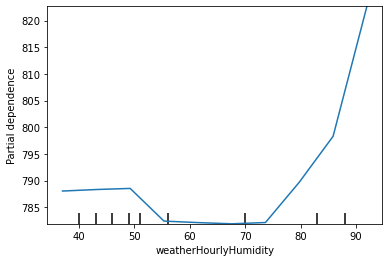

In [33]:
PD_plot(5)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

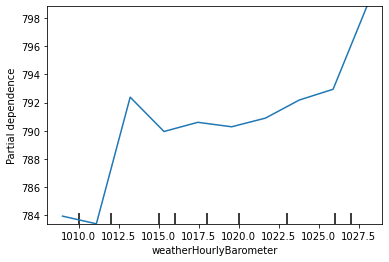

In [34]:
PD_plot(6)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

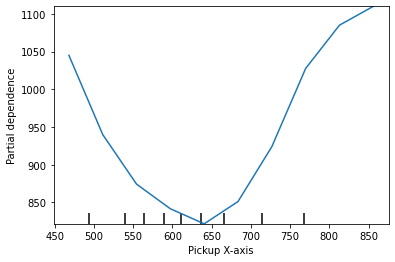

In [35]:
PD_plot(7)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

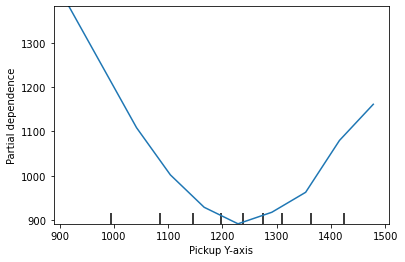

In [36]:
PD_plot(8)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

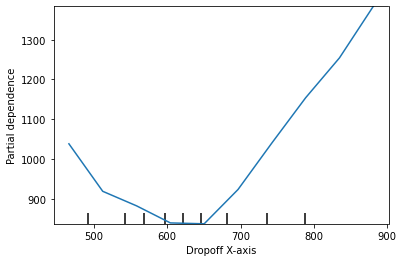

In [37]:
PD_plot(9)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

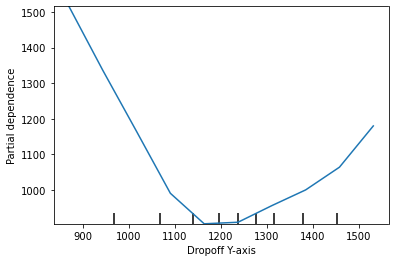

In [38]:
PD_plot(10)#<--- To plot a feature, change the number according to the feature (between 0 and 10)

# 4. Feature importance with Eli5.

In [39]:
import eli5
from eli5 import show_weights
from eli5 import show_prediction

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [40]:
eli5.show_weights(model, feature_names = feature_set)

Weight,Feature
0.2205,Pickup X-axis
0.1753,Dropoff X-axis
0.1733,Pickup Y-axis
0.1381,Dropoff Y-axis
0.0978,TripStartTime
0.0530,startTimeDay
0.0381,startTimeWeek
0.0344,weatherHourlyTemp
0.0274,weatherHourlyBarometer
0.0261,weatherHourlyHumidity


In [139]:
#eli5.show_prediction(model, X_test[0], feature_names=feature_set, show_feature_values=False)
eli5.show_prediction(model, X_test.iloc[25])

In [134]:
y_test_predicted[25]

443.95197

In [138]:
 y_test_predicted.mean()

789.2994

In [84]:
from eli5.sklearn import PermutationImportance

In [85]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

In [87]:
eli5.show_weights(perm, feature_names = feature_set)

Weight,Feature
1.3585 ± 0.0061,Dropoff Y-axis
1.1112 ± 0.0095,Pickup Y-axis
0.8613 ± 0.0065,Dropoff X-axis
0.8253 ± 0.0044,Pickup X-axis
0.2360 ± 0.0016,TripStartTime
0.0197 ± 0.0005,startTimeDay
0.0156 ± 0.0005,weatherHourlyTemp
0.0112 ± 0.0003,weatherHourlyHumidity
0.0061 ± 0.0001,weatherHourlyBarometer
0.0029 ± 0.0001,weatherHourlyWind
